In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


**Libraries Import**

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

**Read the dataset Fetures Extraction**

In [ ]:
df = pd.read_csv("/content/no_show_dataset_adjusted.csv")
target = "no_show"
categorical_features = ["center_id", "service_type", "day_of_week"]
features = [col for col in df.columns if col != target]

NameError: name 'pd' is not defined

**Train and Test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)
#----------------------------------------------------------------------------
pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print("Scale_pos_weight:", pos_weight)

Scale_pos_weight: 3.4309055663251176


**Model Training**

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_features)


model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    eval_metric="F1",
    scale_pos_weight=pos_weight,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.6044777	test: 0.6048940	best: 0.6048940 (0)	total: 53.1ms	remaining: 21.2s
100:	learn: 0.6274203	test: 0.6328186	best: 0.6328694 (61)	total: 4.76s	remaining: 14.1s
200:	learn: 0.6338292	test: 0.6328186	best: 0.6328694 (61)	total: 8.47s	remaining: 8.39s
300:	learn: 0.6435080	test: 0.6295024	best: 0.6333778 (220)	total: 12.6s	remaining: 4.15s
399:	learn: 0.6541127	test: 0.6221550	best: 0.6333778 (220)	total: 18.4s	remaining: 0us

bestTest = 0.6333778499
bestIteration = 220

Shrink model to first 221 iterations.


**The Results**

In [ ]:
# the result
y_pred = model.predict(X_test)

#Add model Result to the dataframe
X_test["pred_no_show"] = y_pred

#show the first 10 results
print(X_test[["pred_no_show"]].head(10))


       pred_no_show
2599              0
39587             1
26696             1
24111             1
13474             1
25123             0
9112              0
20910             1
24781             0
24404             0


**The Confusion Metrics**

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", round(roc_auc, 4))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.72      6195
           1       0.33      0.64      0.44      1805

    accuracy                           0.63      8000
   macro avg       0.59      0.63      0.58      8000
weighted avg       0.74      0.63      0.66      8000

ROC AUC Score: 0.6776


**The Affected Fetures**

In [ ]:
importance = model.get_feature_importance(prettified=True)
print("\nFeature Importance:")
print(importance)


Feature Importance:
               Feature Id  Importances
0       notification_sent    31.909208
1  previous_no_show_count    25.153054
2                    hour    21.827421
3            service_type     7.084128
4             day_of_week     4.324718
5          appointment_id     3.733878
6               center_id     3.189565
7                 user_id     2.778028


**Plot the Fetures**

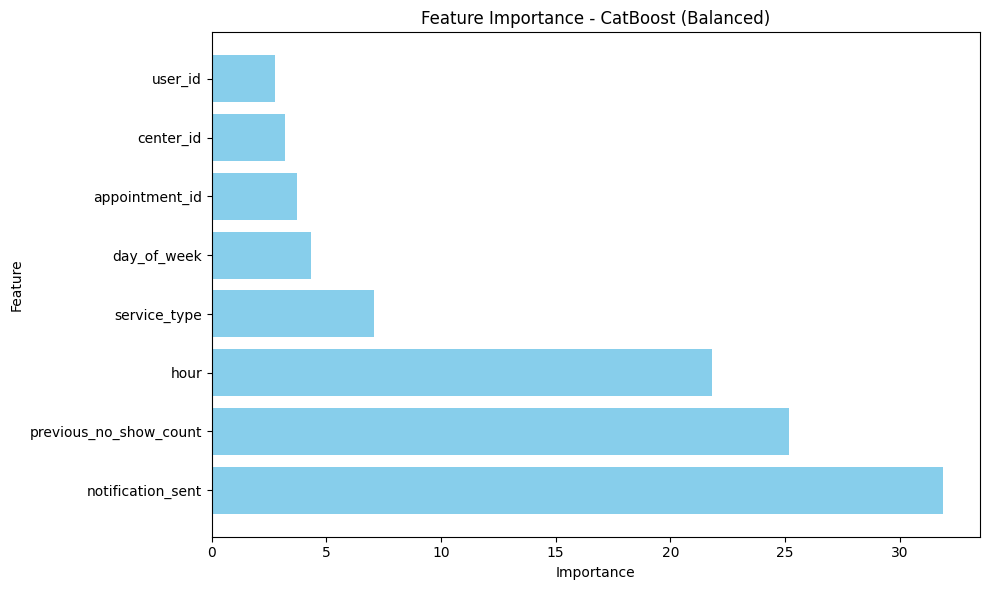

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(importance["Feature Id"], importance["Importances"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - CatBoost (Balanced)")
plt.tight_layout()
plt.show()